In [1]:
#s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"
data_dir = "temp"

In [2]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008 $data_dir --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/validation_scores_epoch_Objectdump_20190909_131343_5980a68d-3c92-48cb-af94-7cd2c807f9ae.json to temp/validation_scores_epoch_Objectdump_20190909_131343_5980a68d-3c92-48cb-af94-7cd2c807f9ae.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/training_scores_epoch_Objectdump_20190909_131343_445f2544-789e-4c08-9f72-5a85c53d4f1b.json to temp/training_scores_epoch_Objectdump_20190909_131343_445f2544-789e-4c08-9f72-5a85c53d4f1b.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/run.log to temp/run.log
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/predicted_AIMedval.json to temp/predicted_AIMedval.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190909_1008/predicted_AIMedtest.json to temp/predicted_AIMedtest.json


In [3]:
!ls  $data_dir

predicted_AIMedtest.json
predicted_AIMedval.json
run.log
training_scores_epoch_Objectdump_20190909_131343_445f2544-789e-4c08-9f72-5a85c53d4f1b.json
validation_scores_epoch_Objectdump_20190909_131343_5980a68d-3c92-48cb-af94-7cd2c807f9ae.json


In [4]:
!head -1 $data_dir/run.log 

commit 075193db228696f558bbbcf127413bb27467a342


In [5]:
!head -10 $data_dir/run.log | tail -8

Date:   Mon Sep 9 19:55:47 2019 +1000

    Use pad zero tokens
{'dataset': 'PpiAimedDataset', 'trainjson': '/data/AIMedtrain.json', 'valjson': '/data/AIMedval.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_PpiAimedDataset_CnnPos_190909_1008', 'epochs': 200, 'interaction_type': None, 'log_level': 'INFO'}
2019-09-09 10:08:03,570 - __main__ - INFO - The embedding header is 5443656 200

2019-09-09 10:08:03,571 - algorithms.RelationExtractorBiLstmNetwork - INFO - The text feature is index 0, the feature lengths are [150   1   1]
2019-09-09 10:08:03,572 - algorithms.RelationExtractorBiLstmNetwork - INFO - Word embedding size is 200, pos embedding size is 6, totaldim is 206, hidden_size  150


In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [7]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [29]:
import glob

results_file = "./{}/predicted_AIMedtest.json".format(data_dir)
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [30]:
#download_single_file(s3_data, results_file)

In [31]:
import pandas as pd

In [32]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [33]:
df_results.head(n=3)

,docid,isValid,line_no,participant1,participant2,passage,predicted,confidence_scores,confidence_true,confidence_false,actual
0,abstract_11780382,False,6,IFN - alpha,IL - 4,"Cytokines measurements during IFN - alpha treatment showed a trend to decreasing levels of IL - 4 at 4 , 12 , and 24 weeks .",False,"{'False': 13.0466365814, 'True': -5.5720143318}",0.003803,463534.725531,False
1,abstract_11780382,False,7,IFN - alpha,IFN - gamma,Levels of IFN - gamma were slightly increased following IFN - alpha treatment ( P = 0.09 ) .,False,"{'False': 11.8266267776, 'True': -5.3124694824}",0.004930,136848.092759,False
1020,abstract_for_1833068,False,1,CDC2,cyclin E,"TI - Human cyclin E , a new cyclin that interacts with two members of the CDC2 gene family .",False,"{'False': 7.8738045692, 'True': -4.1671004295}",0.015497,2627.543266,False


In [34]:
df_results.columns


Index(['docid', 'isValid', 'line_no', 'participant1', 'participant2',
       'passage', 'predicted', 'confidence_scores', 'confidence_true',
       'confidence_false', 'actual'],
      dtype='object')

## Analyse Results

In [35]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [36]:
df = df_results

In [37]:
df_results.shape

(590, 11)

In [38]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=3)

,true,false,actual,predicted,confidence_scores
1665,73.278145,0.117768,True,True,"{'False': -2.1390388012, 'True': 4.2942624092}"
1881,54.141435,0.067151,True,True,"{'False': -2.7008144855, 'True': 3.9915997982}"
2924,22.998443,0.209310,True,True,"{'False': -1.5639388561, 'True': 3.1354265213}"


In [39]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"], sample_weight=None)  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))



The F1 score is 0.41237113402061853 and the accuracy is 0.8067796610169492


In [40]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


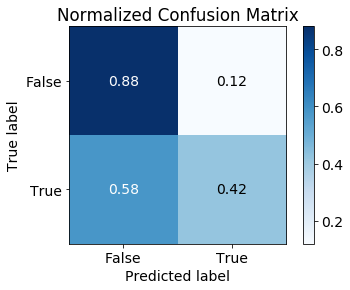

In [41]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

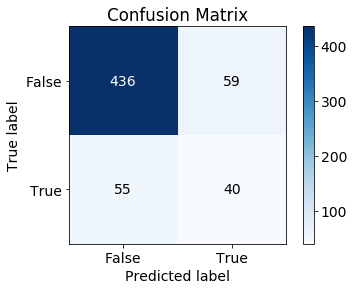

In [42]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

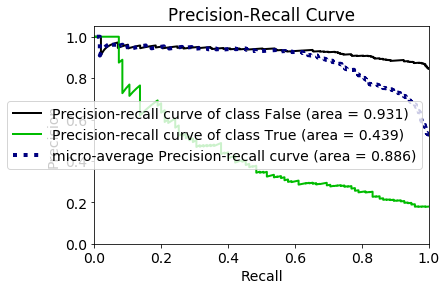

In [43]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

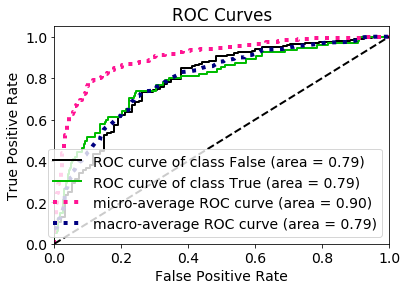

In [61]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_roc(df["actual"], df[["false", "true"]])

## Training / Validation epoch fit

In [44]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [45]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] = df_train_fit["score"] * 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)


,epoch,loss,score
39,39,1.238613,98.166432
42,42,2.225085,97.602257
38,38,2.165141,97.464789
40,40,1.653239,97.297297
37,37,1.858943,96.737589
34,34,2.861336,96.348315
35,35,3.234205,95.590327
32,32,3.138373,95.319149
41,41,2.734490,94.452347
31,31,3.808084,93.714286


In [46]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] = df_val_fit["score"] * 100
df_val_fit.sort_values(["loss"], ascending=True).head(n=10)

,epoch,loss,score
10,10,3.212561,42.424242
7,7,3.261491,31.578947
8,8,3.274903,43.076923
11,11,3.474388,52.380952
5,5,3.638801,9.302326
4,4,3.674910,0.000000
2,2,3.771210,0.000000
6,6,3.773231,36.065574
12,12,3.845643,54.347826
3,3,4.008905,33.333333


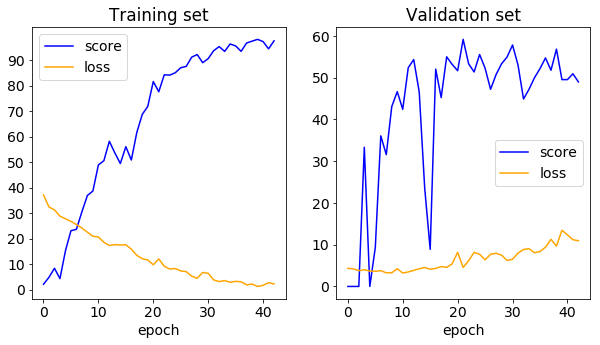

In [47]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color="orange")
ax[0].set_title("Training set")
ax[0].yaxis.set_major_locator(plt.FixedLocator( range(0, 100, 10)))

df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color ="orange")

ax[1].set_title("Validation set")
ax[1].yaxis.set_major_locator(plt.FixedLocator(range(0, 100,10)))



plt.show()

### Threshold 

In [48]:
threshold = .95
df_trues = df.query("true > {}".format(threshold))
df_trues.shape

(141, 13)

In [49]:
from sklearn.metrics import f1_score, accuracy_score, precision_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"])  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)


print("The F1 score is {} and the accuracy is {}, precision {}".format(f1, accuracy, precision))

The F1 score is 0.5405405405405406 and the accuracy is 0.5177304964539007, precision 0.40404040404040403
